In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 
# little entropy to break symmetry W2
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we dont need bias to have some effect during intialization

# BatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, b1]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [50]:
 # same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # random batch of indices
    Xb, Yb = Xtr[ix], Ytr[ix] # fetch the batch from the dataset

    #  forward pass
    emb = C[Xb] # embed the character vectors
    # print(emb.shape[0])
    embcat = emb.view(emb.shape[0], -1) # concatenate the embedding vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # 32 100
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # cross-entropy loss

  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break


      0/ 200000: 3.3221


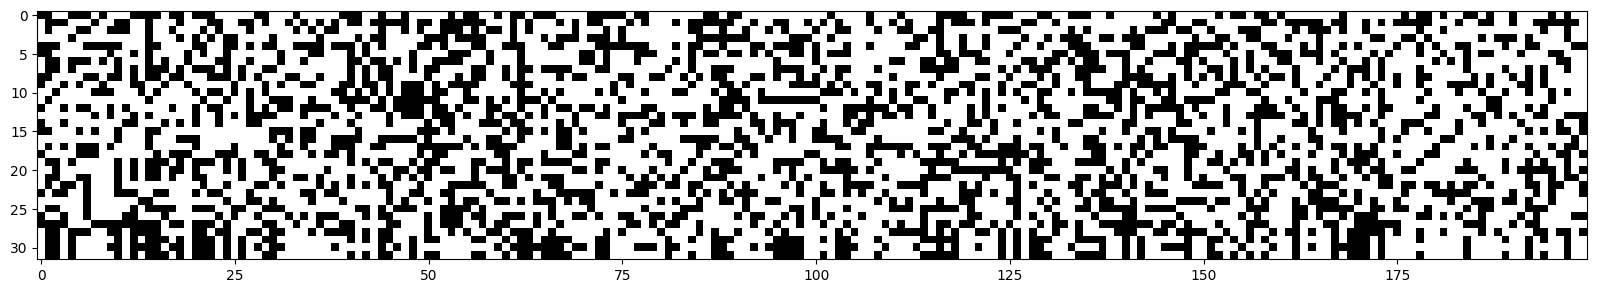

In [60]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

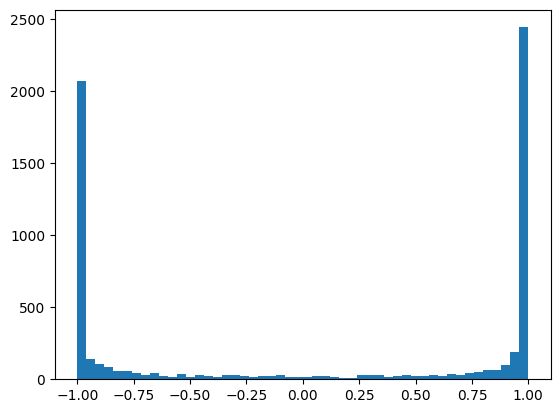

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50);
# If the activaiton after tanh has 1 or -1 they wont be able to lear from backpropagation,
# as the gradient will be 0. and if the gradient is 0, the weights wont be updated.
# This is a problem of vanishing gradients, and it can be solved with batch normalization.
# If the activaiton after tanh is 0 during backpropagation, the gradient will be 1, and the weights will be updated.

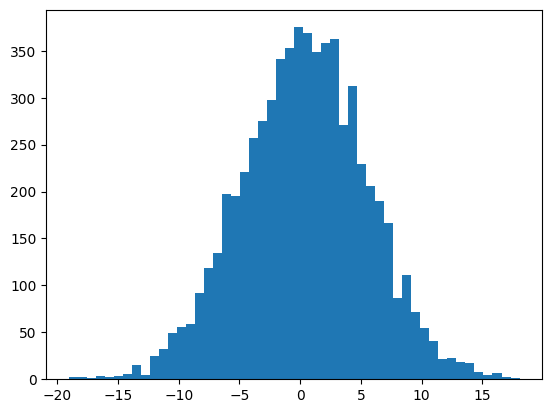

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50);
# the hpreact is two large and the tanh is saturated i.e, the hpreact values once goes through tanh,
# it becomes 1 or -1. This is not good for the training.

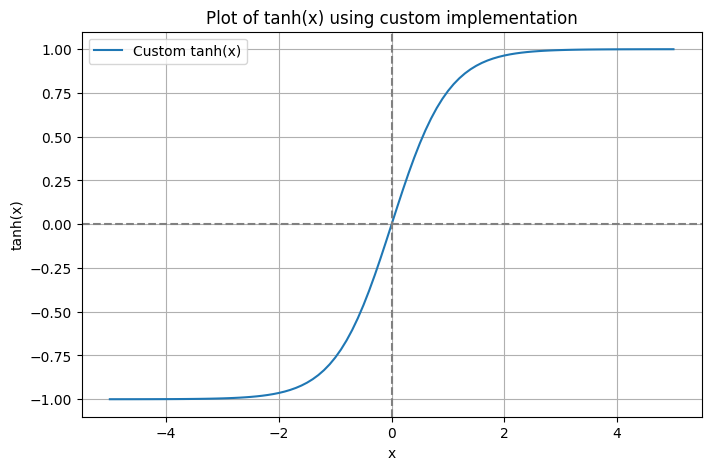

In [62]:
import math
import matplotlib.pyplot as plt

# Define custom tanh function
def tanh(x):
    e_pos = math.exp(x)
    e_neg = math.exp(-x)
    return (e_pos - e_neg) / (e_pos + e_neg)

# Generate x values and compute y values using custom tanh
x_vals = [x * 0.1 for x in range(-50, 51)]  # x from -5.0 to 5.0
y_vals = [tanh(x) for x in x_vals]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label="Custom tanh(x)")
plt.title("Plot of tanh(x) using custom implementation")
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True)
plt.legend()
plt.show()


In [47]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(h) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0935378074645996
val 2.145049571990967





Show in Settings Editor

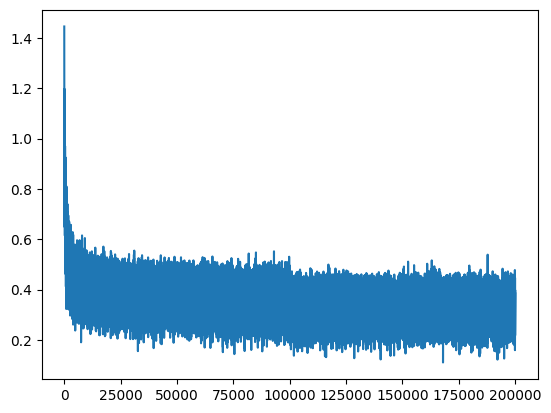

In [10]:
plt.plot(lossi)

In [ ]:
# at intializtion the prob for any character without any context is 1/27
-torch.tensor(1/27.0).log()

In [31]:
# 4 dimensional example
logits = torch.tensor([5.0, 5.0, 5.0, 5.0])
# logis = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs.log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1.3863, 1.3863, 1.3863, 1.3863]))